**References:** Chapter 17 of Geron's book. For 1-Dim plots, Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains a VAE with the instances of the normal digits in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digits in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated.

In [241]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [242]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

### **Loading the MNIST data and forming arrays of the normal training data, the validation data (normal and abnormal) and the test data (normal and abnormal)**

In [243]:
#Labels
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

nl1 = 5  
nl2 = 7   
nl3 = 9
abn1 = 4  
abn2 = 4

(x_train_0, y_train_0), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train_0 = x_train_0.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

train_size = x_train_0.shape[0] * 9 // 10

x_train, x_valid, y_train, y_valid = train_test_split(x_train_0, y_train_0, train_size = train_size)

normal_data = x_train[(y_train == nl1) | (y_train == nl2) | (y_train == nl3)]        # Normal training data (Normal digitss)
normal_labels = y_train[(y_train == nl1) | (y_train == nl2) | (y_train == nl3)]

valid_data = x_valid[(y_valid == abn1) | (y_valid == abn2) | (y_valid == nl1) | (y_valid == nl2) | (y_valid == nl3)]    # Test data (both normal digits and the abnormal digit)
valid_labels = y_valid[(y_valid == abn1) | (y_valid == abn2) | (y_valid == nl1) | (y_valid == nl2) | (y_valid == nl3)]

test_data = x_test[(y_test == abn1) | (y_test == abn2) | (y_test == nl1) | (y_test == nl2) | (y_test == nl3)]    # Test data (both normal digits and the abnormal digit)
test_labels = y_test[(y_test == abn1) | (y_test == abn2) | (y_test == nl1) | (y_test == nl2) | (y_test == nl3)]

test_labels_T_F = np.where((test_labels == nl1) | (test_labels == nl2) | (test_labels == nl3), True, False)
# Array of T and F, T where test digits are normal and F where test digits are abnormal

valid_labels_T_F = np.where((valid_labels == nl1) | (valid_labels == nl2) | (valid_labels == nl3), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

In [244]:
normal_data.shape, normal_labels.shape, valid_data.shape, valid_labels.shape, test_data.shape, test_labels.shape

((16198, 28, 28), (16198,), (2403, 28, 28), (2403,), (4000, 28, 28), (4000,))

In [245]:
normal_test_data = test_data[(test_labels == nl1) | (test_labels == nl2) | (test_labels == nl3)]            # The normal digits in the test data
abnormal_test_data = test_data[(test_labels == abn1) | (test_labels == abn2)]        # The abnormal digits in the test data
normal_test_labels = test_labels[(test_labels == nl1) | (test_labels == nl2) | (test_labels == nl3)]        # Their labels
abnormal_test_labels = test_labels[(test_labels == abn1) | (test_labels == abn2)]    # Their labels

In [246]:
normal_test_data.shape, abnormal_test_data.shape

((3000, 28, 28), (1000, 28, 28))

In [247]:
normal_valid_data = valid_data[(valid_labels == nl1) | (valid_labels == nl2) | (valid_labels == nl3)]            # The normal digits in the valid data
abnormal_valid_data = valid_data[(valid_labels == abn1) | (valid_labels == abn2)]        # The abnormal digits in the test data
normal_valid_labels = valid_labels[(valid_labels == nl1) | (valid_labels == nl2) | (valid_labels == nl3)]        # Their labels
abnormal_valid_labels = valid_labels[(valid_labels == abn1) | (valid_labels == abn1)]    # Their labels

In [248]:
normal_valid_data.shape, abnormal_valid_data.shape

((1802, 28, 28), (601, 28, 28))

### **Building and training the network** 

In [249]:
K = keras.backend
# def rounded_accuracy(y_true, y_pred):
  #  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [250]:
# For details please see Geron's book. Uses the reparametrization trick to do stochastic 
# sampling from the MVN distribution, while allowing the 2 parallel layers containing the 
# means and stds of the MVN distribution for each dimension to be trained via 
# backpropogation of the error signal.
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [251]:
# For details please see Geron's book. 
codings_size = 16   # The number of dimensions of the MVN distribution in the sampling layer

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(256, activation="selu")(z)
z = keras.layers.Dense(128, activation="selu")(z)
z = keras.layers.Dense(64, activation="selu")(z)

# Parallel layers at the end of the encoder for means 
# and standard deviations of the Multivariate Normal (MVN) distribution 
# in the dimensions of the coding size (here 32). 
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

# Sampling layer at the end of the encoder
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(64, activation="selu")(decoder_inputs)
x = keras.layers.Dense(128, activation="selu")(x)
x = keras.layers.Dense(256, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# The latent loss function
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

# Add the latent loss to the reconstruction loss
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# For the reconstruction loss binary cross-entropy loss is used. 
# For details please see Chapter 17 of Geron's book (Stacked AE and VAE sections) 
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

checkpoint_cb = keras.callbacks.ModelCheckpoint("VAE_model", monitor="val_loss", save_best_only=True)

history = variational_ae.fit(normal_data, normal_data, epochs=100, batch_size=128, callbacks=[checkpoint_cb],
                             validation_data=(normal_valid_data, normal_valid_data), shuffle=True)

Epoch 1/100
127/127 [==============================] - 4s 24ms/step - loss: 0.3475 - val_loss: 0.2953
Epoch 2/100
127/127 [==============================] - 3s 21ms/step - loss: 0.2907 - val_loss: 0.2876
Epoch 3/100
127/127 [==============================] - 3s 20ms/step - loss: 0.2792 - val_loss: 0.2808
Epoch 4/100
127/127 [==============================] - 3s 23ms/step - loss: 0.2725 - val_loss: 0.2783
Epoch 5/100
127/127 [==============================] - 3s 21ms/step - loss: 0.2666 - val_loss: 0.2698
Epoch 6/100
127/127 [==============================] - 3s 23ms/step - loss: 0.2633 - val_loss: 0.2610
Epoch 7/100
127/127 [==============================] - 1s 6ms/step - loss: 0.2608 - val_loss: 0.2634
Epoch 8/100
127/127 [==============================] - 1s 7ms/step - loss: 0.2590 - val_loss: 0.2651
Epoch 9/100
127/127 [==============================] - 3s 21ms/step - loss: 0.2573 - val_loss: 0.2586
Epoch 10/100
127/127 [==============================] - 3s 21ms/step - loss: 0.2560 

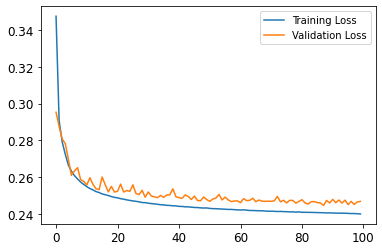

In [252]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [253]:
model = variational_ae
model.summary(expand_nested=True, show_trainable=True)

Model: "model_14"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_9 (InputLayer)           [(None, 28, 28)]     0           []                               Y          
                                                                                                             
 model_12 (Functional)          [(None, 16),         244192      ['input_9[0][0]']                Y          
                                 (None, 16),                                                                 
                                 (None, 16)]                                                                 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_9 (InputLayer)         [(None, 28, 28)]     0           []                               Y    

In [254]:
model_encoder = variational_encoder
# model_encoder.summary(expand_nested=True, show_trainable=True)

In [255]:
model_decoder = variational_decoder
# model_decoder.summary(expand_nested=True, show_trainable=True)

In [256]:
model_layers = np.array(model.layers)
n_layers = model_layers.shape[0] 
# np.concatenate((np.arange(n_layers).reshape(n_layers,1), model_layers.reshape(n_layers,1)), axis = 1)

### **The original and reconstructed images for the first 30 instances of the normal training data, validation data, normal validation data, abnormal validation data, test data, normal test data, and abnormal test data**

In [257]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [258]:
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

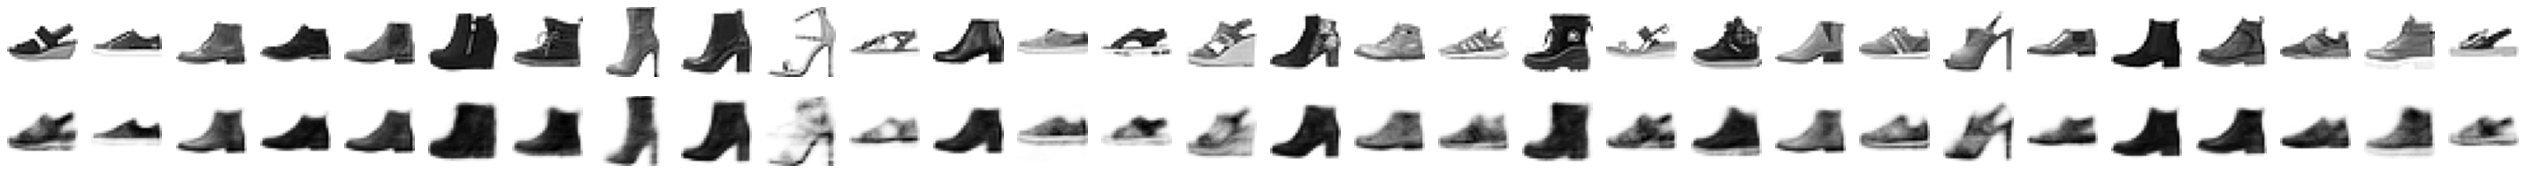

In [259]:
show_reconstructions(variational_ae, normal_data, 30)
plt.show()

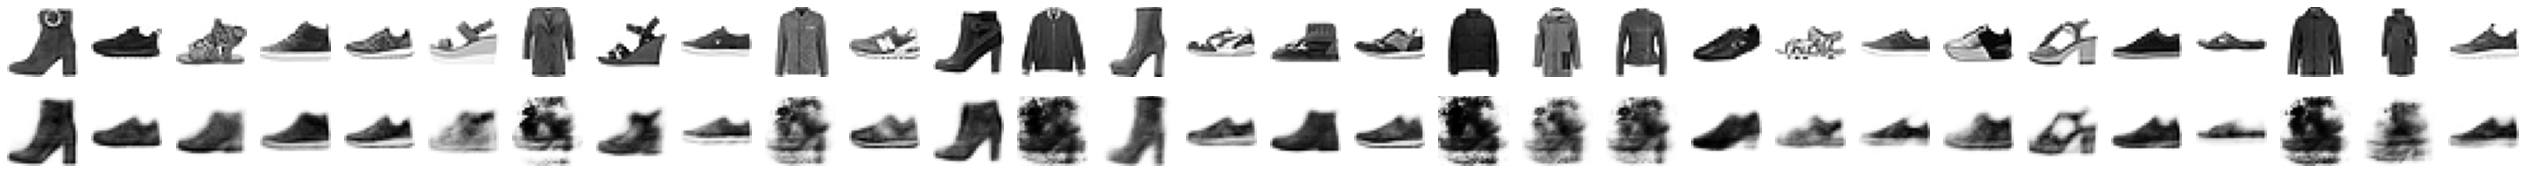

In [260]:
show_reconstructions(variational_ae, valid_data, 30)
plt.show()

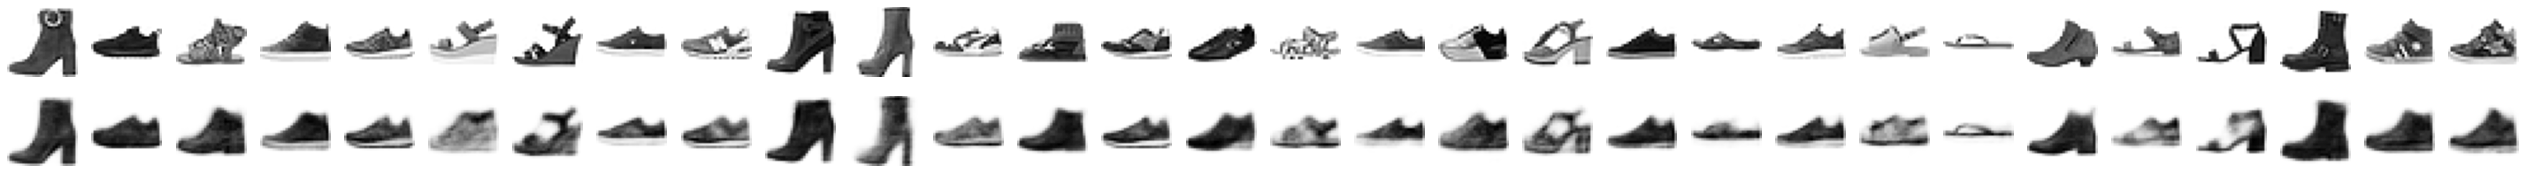

In [261]:
show_reconstructions(variational_ae, normal_valid_data, 30)
plt.show()

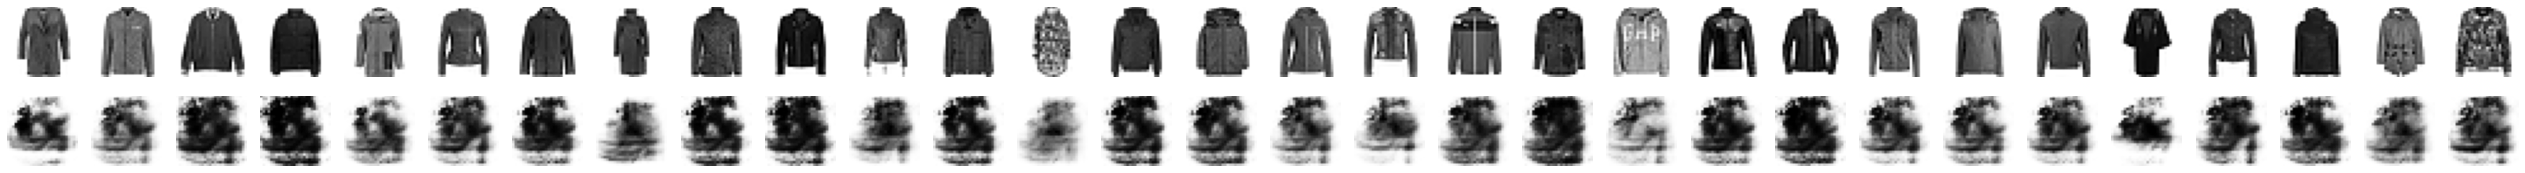

In [262]:
show_reconstructions(variational_ae, abnormal_valid_data, 30)
plt.show()

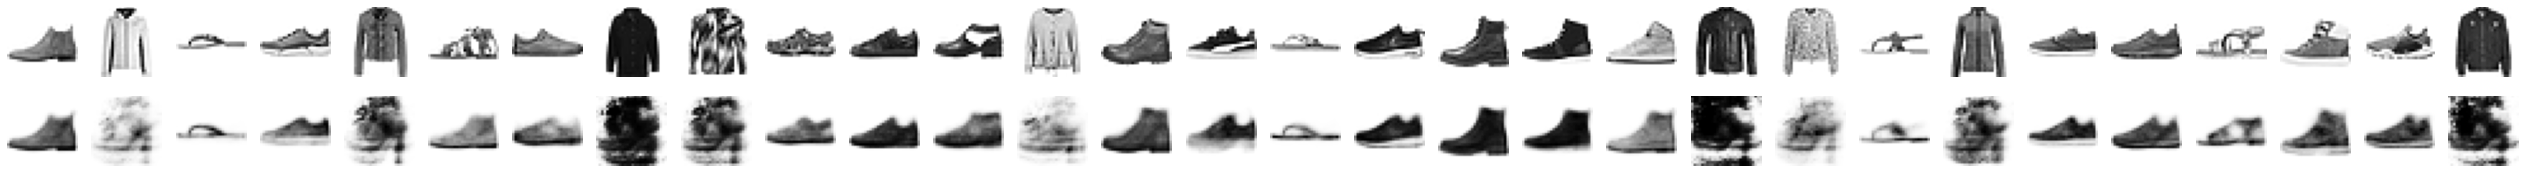

In [263]:
show_reconstructions(variational_ae, test_data, 30)
plt.show()

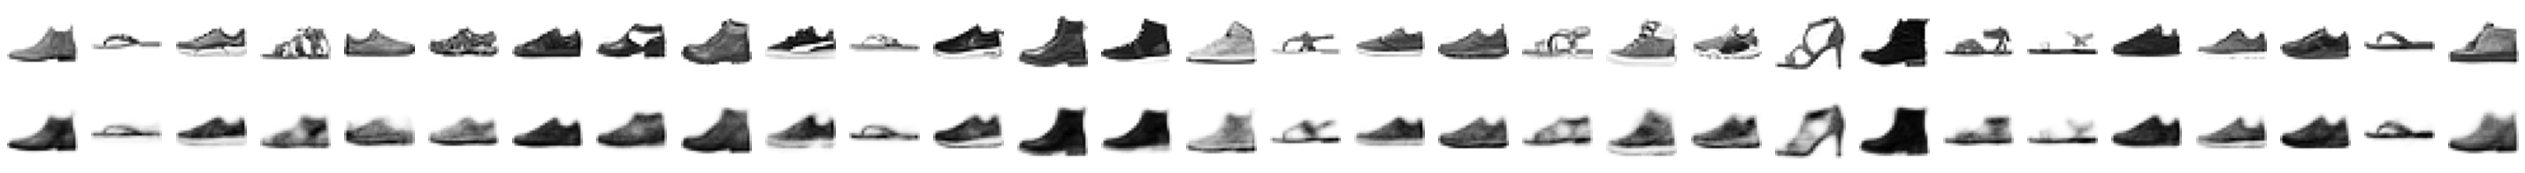

In [264]:
show_reconstructions(variational_ae, normal_test_data, 30)
plt.show()

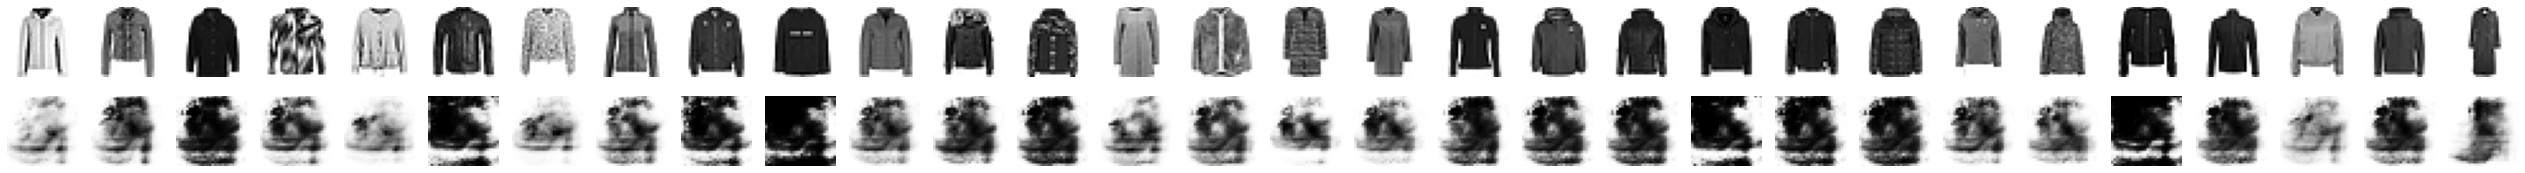

In [265]:
show_reconstructions(variational_ae, abnormal_test_data, 30)
plt.show()

**1-Dim plot of pixels of the first normal test data**

In [266]:
reconstructions_nl_test = variational_ae.predict(normal_test_data)

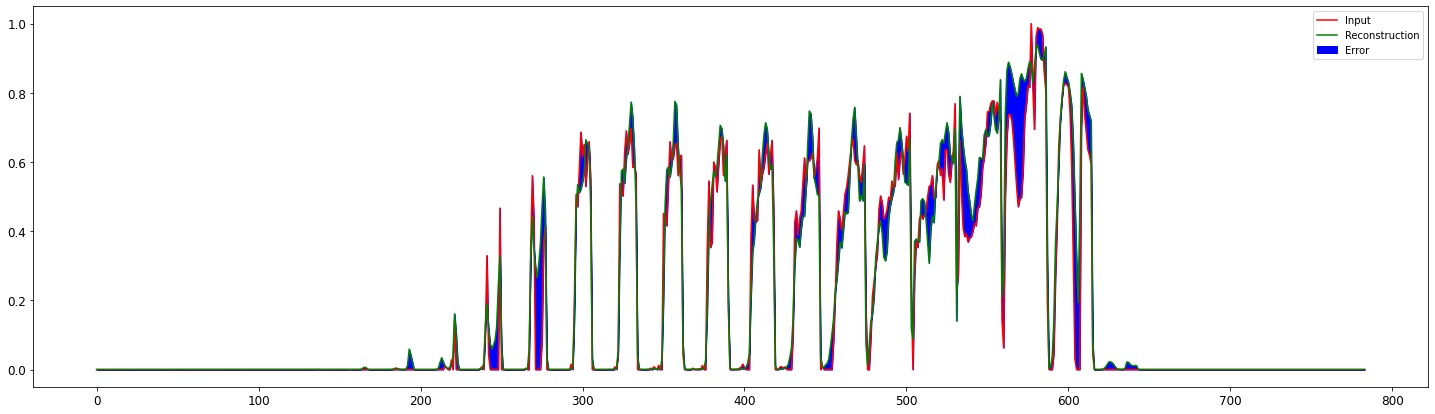

In [267]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_nl_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_nl_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**1-Dim plot of pixels of the first abnormal test data**

In [268]:
reconstructions_abn_test = variational_ae.predict(abnormal_test_data)

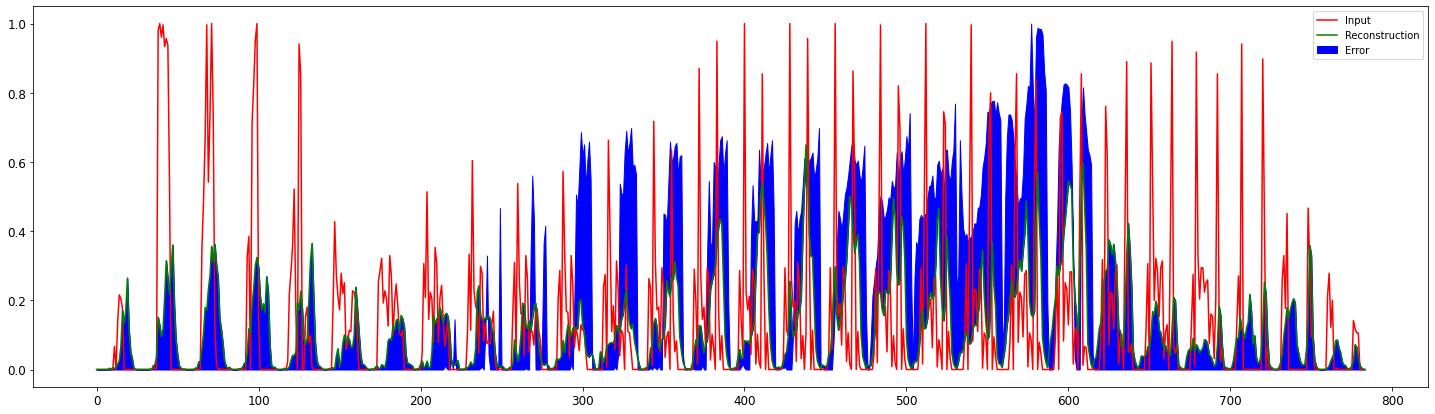

In [269]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_abn_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_abn_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### **Distributions of the reconstruction losses and the calculation of the threshold.**

**Distribution of the reconstruction losses of the normal training data**

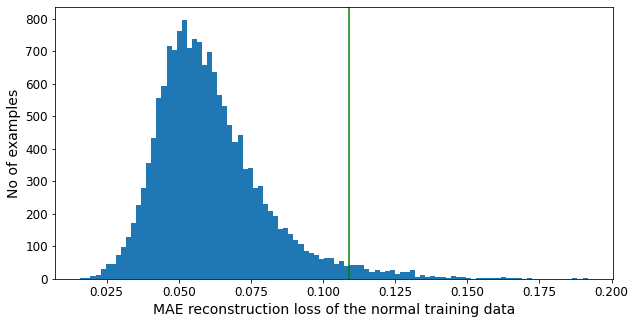

In [270]:
reconstructions = variational_ae.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.figure(figsize=(10,5))
plt.hist(train_loss[None,:], bins=100)
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the normal training data")
plt.ylabel("No of examples")
plt.show()

In [271]:
mean1 = np.mean(train_loss)
std1 = np.std(train_loss)
print("Mean: ", mean1)
print("Std: ", std1)

Mean:  0.061147418
Std:  0.019206136


In [272]:
threshold_train_mean_2_5_std = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std: ", threshold_train_mean_2_5_std)

Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std:  0.10916275903582573


In [273]:
threshold1 = threshold_train_mean_2_5_std

**Distribution of the reconstruction losses of the abnormal validation data**

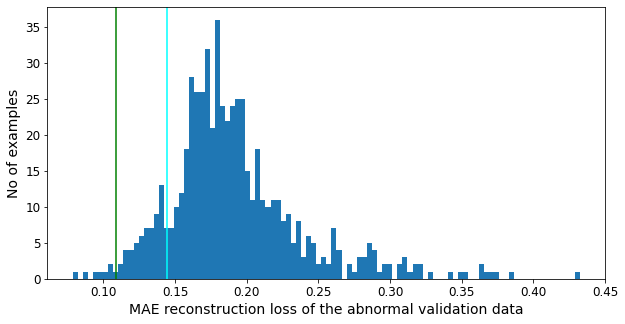

In [274]:
reconstructions = variational_ae.predict(abnormal_valid_data)
abn_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(abn_valid_loss[None, :], bins=100)
threshold2 = np.mean(abn_valid_loss) - np.std(abn_valid_loss)
plt.axvline(threshold2,c='cyan')
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the abnormal validation data")
plt.ylabel("No of examples")
plt.show()

In [275]:
abnormal_valid_mean_loss = np.mean(abn_valid_loss)

In [276]:
abnormal_valid_mean_loss , np.std(abn_valid_loss)

(0.19182919, 0.047329407)

In [277]:
threshold2 = abnormal_valid_mean_loss - np.std(abn_valid_loss)
print("Threshold2: ", threshold2)

Threshold2:  0.14449978


**Distribution of the reconstruction losses of the normal validation data**

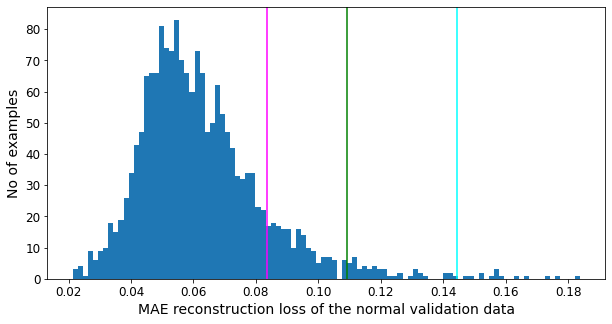

In [278]:
reconstructions = variational_ae.predict(normal_valid_data)
nl_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(nl_valid_loss[None, :], bins=100)
threshold3 = np.mean(nl_valid_loss) + np.std(nl_valid_loss)
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold1, c='g')
plt.xlabel("MAE reconstruction loss of the normal validation data")
plt.ylabel("No of examples")
plt.show()

In [279]:
normal_valid_mean_loss = np.mean(nl_valid_loss)

In [280]:
normal_valid_mean_loss , np.std(nl_valid_loss)

(0.0628205, 0.020704594)

In [281]:
threshold3 = normal_valid_mean_loss + np.std(nl_valid_loss)
print("Threshold3: ", threshold3)

Threshold3:  0.08352509


**Calculation of a preliminary threshold based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)**

In [282]:
Avg_of_threshold_2_3 = (threshold2 + threshold3)/2
print("Average of threshold 2 and 3: ", Avg_of_threshold_2_3)

Average of threshold 2 and 3:  0.11401243507862091


In [283]:
threshold4 = Avg_of_threshold_2_3

### **Calculation of the threshold that gives the best accuracy on the validation data and set this as the threshold.**

In [284]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

In [285]:
increment = (abnormal_valid_mean_loss- normal_valid_mean_loss)/100
thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, increment)
thrs_size = thresholds.shape[0]
accuracies = np.zeros(thrs_size)
for i in range(thrs_size):
  preds = predict(variational_ae, valid_data, thresholds[i])
  accuracies[i] = accuracy_score(preds, valid_labels_T_F)
argmax = np.argmax(accuracies)
valid_data_best_threshold = thresholds[argmax]
print("The best threshold based on validation data: ", valid_data_best_threshold)

The best threshold based on validation data:  0.11958432108163819


In [286]:
thr_acc = np.zeros((thrs_size, 2))
thr_acc[:, 0] = thresholds
thr_acc[:, 1] = accuracies
thr_acc[argmax-2:argmax+3]

array([[0.11700415, 0.97877653],
       [0.11829423, 0.97919268],
       [0.11958432, 0.98002497],
       [0.12087441, 0.97877653],
       [0.12216449, 0.97877653]])

In [287]:
threshold5 = valid_data_best_threshold

In [288]:
threshold = threshold5

#### **Distribution of the reconstruction losses of all the validation data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

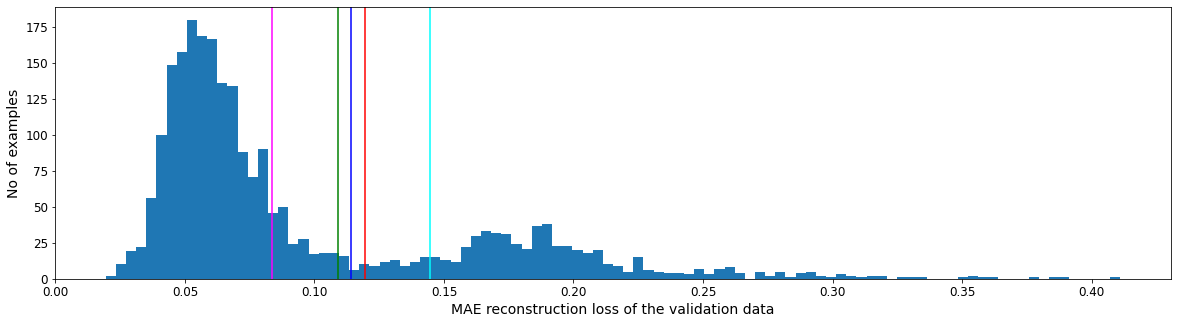

In [289]:
reconstructions = variational_ae.predict(valid_data)
valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), valid_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(valid_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the validation data")
plt.ylabel("No of examples")
plt.show()

#### **Distribution of the reconstruction losses of the test data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

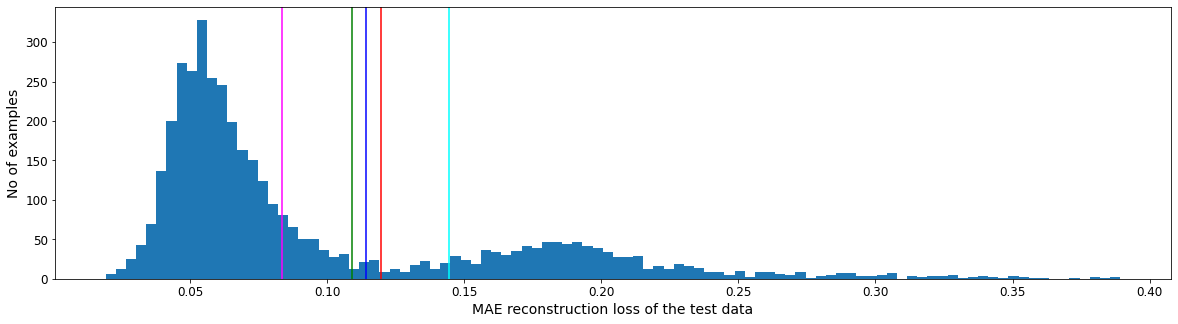

In [290]:
reconstructions = variational_ae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(test_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the test data")
plt.ylabel("No of examples")
plt.show()

#### **Mean and standard deviation of reconstruction losses for normal and abnormal test data**

In [291]:
reconstructions = variational_ae.predict(normal_test_data)
nl_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_test_data.reshape(-1,784))
np.mean(nl_test_loss) , np.std(nl_test_loss)

(0.06247108, 0.020700144)

In [292]:
reconstructions = variational_ae.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.19584967, 0.050673388)

### **Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data**

In [293]:
# def predict(model, data, threshold):
#  reconstructions = model.predict(data)
#  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
#  return tf.math.less(loss, threshold)

mean_nl_test_loss = np.mean(nl_test_loss)
std_nl_test_loss = np.std(nl_test_loss)

mean_abn_test_loss = np.mean(abn_test_loss)
std_abn_test_loss = np.std(abn_test_loss)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)

  print("mean_nl_test_loss: {}".format(mean_nl_test_loss))
  print("std_nl_test_loss: {}".format(std_nl_test_loss))
  print("mean_abn_test_loss: {}".format(mean_abn_test_loss))
  print("std_abn_test_loss: {}".format(std_abn_test_loss))
  
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [294]:
preds = predict(variational_ae, test_data, threshold)
print_stats(preds, test_labels_T_F)

mean_nl_test_loss: 0.06247108057141304
std_nl_test_loss: 0.02070014365017414
mean_abn_test_loss: 0.19584967195987701
std_abn_test_loss: 0.050673387944698334
Confusion Matrix: 
 prediction: F      T 
             1022   2978
 label: F   [[961   39]    1000
        T    [61   2939]]   3000
Accuracy = 0.975
Precision = 0.9869039623908663
Recall = 0.9796666666666667


In [295]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 961   39]
 [  61 2939]]


#### **Extra accuracy info**
**Just informative. Please record the above accuracy.**

#### Accuracy on the test data with threshold set based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)

In [296]:
preds = predict(variational_ae, test_data, Avg_of_threshold_2_3)
print_stats(preds, test_labels_T_F)

mean_nl_test_loss: 0.06247108057141304
std_nl_test_loss: 0.02070014365017414
mean_abn_test_loss: 0.19584967195987701
std_abn_test_loss: 0.050673387944698334
Confusion Matrix: 
 prediction: F      T 
             1037   2963
 label: F   [[964   36]    1000
        T    [73   2927]]   3000
Accuracy = 0.97275
Precision = 0.9878501518731015
Recall = 0.9756666666666667


#### Accuracy on the test data with threshold set based on the mean of the training data MAE reconstruction losses + 2.5 std

In [297]:
preds = predict(variational_ae, test_data, threshold_train_mean_2_5_std)
print_stats(preds, test_labels_T_F)

mean_nl_test_loss: 0.06247108057141304
std_nl_test_loss: 0.02070014365017414
mean_abn_test_loss: 0.19584967195987701
std_abn_test_loss: 0.050673387944698334
Confusion Matrix: 
 prediction: F      T 
             1065   2935
 label: F   [[964   36]    1000
        T    [101   2899]]   3000
Accuracy = 0.96575
Precision = 0.9877342419080068
Recall = 0.9663333333333334


**Extra Info**

Giving the VAE codings (please see book) (Just informative, not the goal here)

In [298]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

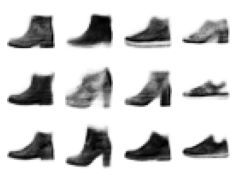

In [299]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
# save_fig("vae_generated_images_plot", tight_layout=False)

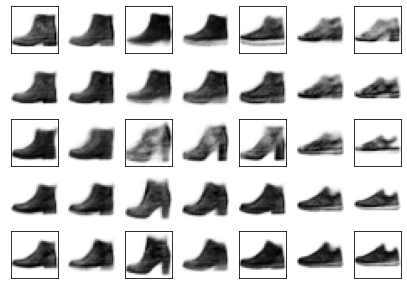

In [300]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
# save_fig("semantic_interpolation_plot", tight_layout=False)